In [4]:
import json
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load Training Data

In [5]:
def read_data(filename):
    with open(filename) as data_file:    
        data = json.load(data_file)
    
    return data

In [6]:
train_file = 'data/train.json'
train_data = read_data(train_file)

## Prepare data

In [42]:
def find_minmax(data):
    mins = [min(min(item['band_1']), min(item['band_2'])) for item in data ]
    maxes = [max(max(item['band_1']), max(item['band_2'])) for item in data ]

    global_min = min(mins)
    global_max = max(maxes)
    
    return global_min, global_max

def find_minmax_angle(data):
    global_min  = min( [item['inc_angle'] for item in data if item['inc_angle'] != 'na'  ])
    global_max = max( [item['inc_angle'] for item in data if item['inc_angle'] != 'na'])
  
    return global_min, global_max

def extract_image(data_item, key, min_value, max_value, image_size = 75):
    image = np.array(data_item[key])
    image = image.reshape(image_size, image_size)

    image = (image - global_min) / (global_max - global_min)
    
    return image
    
def extract_images(data_item, min_value, max_value, image_size = 75):
    hh_image = extract_image(data_item, 'band_1', min_value, max_value, image_size)
    hv_image = extract_image(data_item, 'band_2', min_value, max_value, image_size)
    
    return hh_image, hv_image
     
def display_image(image):
    plt.imshow(image, cmap='gray')
    plt.show()

In [49]:
def prepare_dataset_ignore_angle(data, global_min, gobal_max):
    X =[]
    labels = []
    ids = []
    
    for item in data:
        hh_image, hv_image = extract_images(item, global_min, gobal_max )
        image = np.dstack((hh_image, hv_image))
        X.append(image)
        if 'is_iceberg' in item.keys():
            labels.append(item['is_iceberg'])
        else:
            labels.append(0)
            
        ids.append(item['id'])
    return np.array(X), np.array(labels), np.array(ids)


def prepare_dataset_with_angle(data, global_min, gobal_max, angle_min, angle_max):
    X =[]
    labels = []
    ids = []
    
    for item in data:
        angle = item['inc_angle']
        if angle != 'na':
            hh_image, hv_image = extract_images(item, global_min, gobal_max )
            angle_layer = np.ones_like(hh_image) * (angle_max - angle) / (angle_max - angle_min)
            image = np.dstack((hh_image, hv_image, angle_layer))
            X.append(image)
            if 'is_iceberg' in item.keys():
                labels.append(item['is_iceberg'])
            else:
                labels.append(0)

            ids.append(item['id'])
    return np.array(X), np.array(labels), np.array(ids)

In [50]:
def cut_image_part(data, margin):
    return data[:, margin : -margin, margin : - margin, :]

In [51]:
angle_min, angle_max = find_minmax_angle(train_data)

print(angle_min, angle_max)

24.7546 45.9375


-45.655499 34.574917


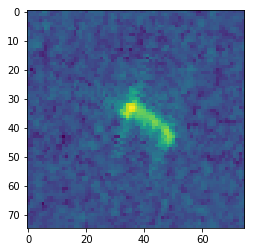

In [52]:
image_size = 75
global_min, global_max = find_minmax(train_data)

#X_train, y_train, _ = prepare_dataset_ignore_angle(train_data, global_min, global_max)
X_train, y_train, _ = prepare_dataset_with_angle(train_data, global_min, global_max, angle_min, angle_max)

print(global_min, global_max)


plt.imshow(X_train[24, :, :, 0])
plt.show()


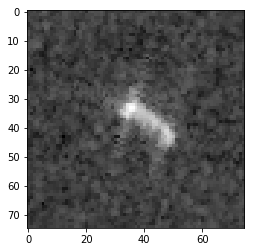

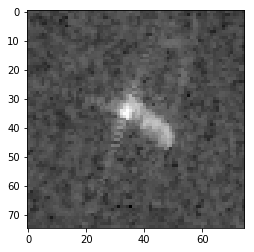

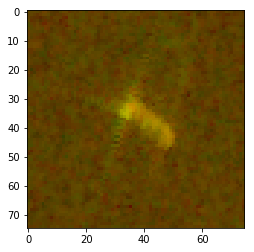

In [53]:
hh_image, hv_image = extract_images(train_data[24], global_min, global_max )
display_image(hh_image)
display_image(hv_image)

image = np.dstack((hh_image, hv_image, np.zeros_like(hv_image)))
plt.imshow(image)
plt.show()

(1471, 75, 75, 3)


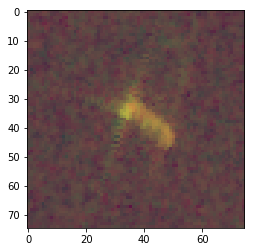

In [54]:
print(X_train.shape)

plt.imshow(X_train[24, :, :])
plt.show()


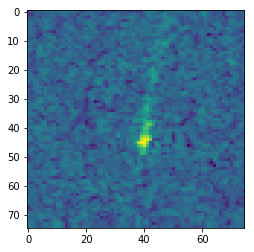

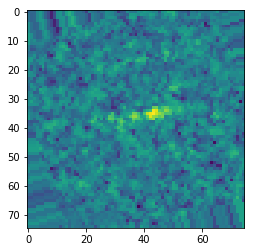

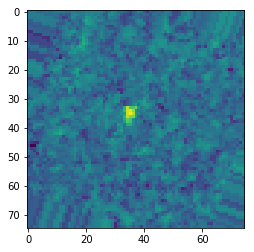

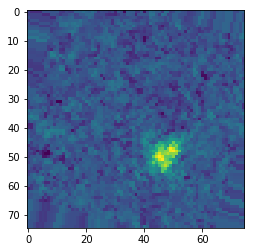

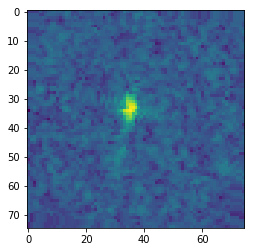

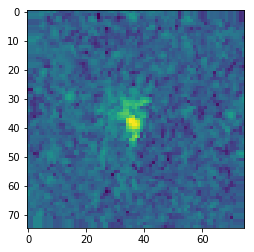

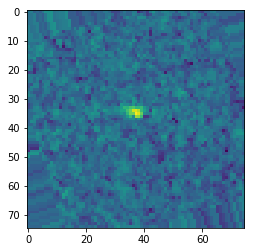

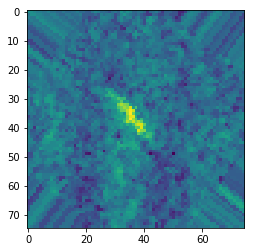

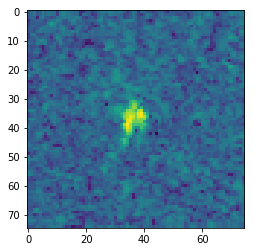

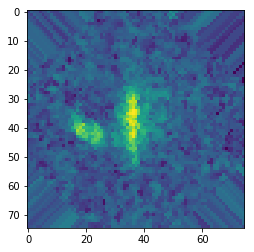

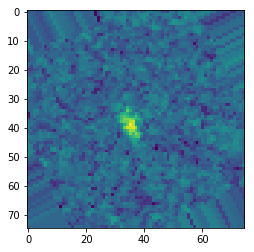

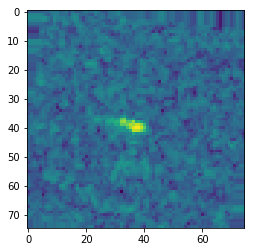

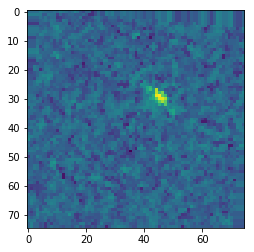

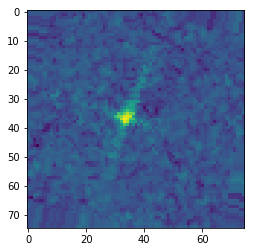

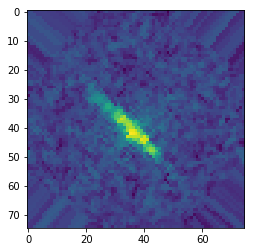

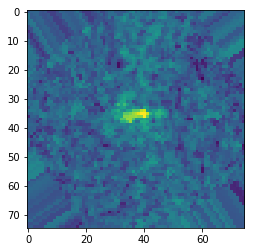

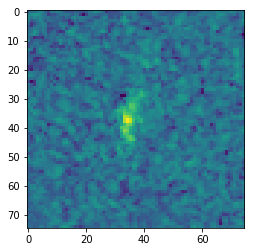

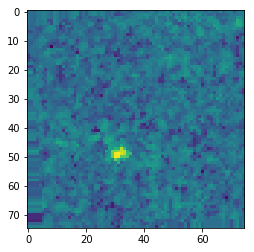

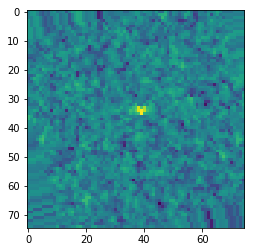

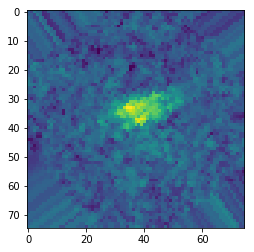

(1471, 75, 75, 3)
(1471, 75, 75, 3)
(30891, 75, 75, 3)


In [94]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=90)
datagen.fit(X_train)

X_train_new = np.copy(X_train)
Y_train_new = np.copy(y_train)

for i in range(20):
    X_batch, y_batch =  next(datagen.flow(X_train, y_train, batch_size=2000))
    X_train_new = np.concatenate((X_train_new, X_batch), axis=0)
    Y_train_new = np.concatenate((Y_train_new, y_batch), axis=0)
    
    plt.imshow(X_batch[24, :, :, 0])
    plt.show()
                                    
    
print(X_batch.shape)


print (X_batch.shape)
#X_train = cut_image_part(X_train_new, 10)
print (X_train_new.shape)







## Model

In [95]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Activation, BatchNormalization
from keras.layers import Flatten, Dense
from keras.initializers import RandomNormal

entities_count = 30

def getModel10(num_layers):
    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same',
                    input_shape=(75, 75, num_layers), use_bias=True))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(1, activation="sigmoid"))
    
    return model


def getModel20(num_layers):
    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same',
                    input_shape=(75, 75, num_layers), use_bias=True))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    #model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True))
    #model.add(Activation('relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(1024, activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation="sigmoid"))
    
    return model

In [96]:
def getModel30(num_layers):
    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same',
                    input_shape=(75, 75, num_layers), use_bias=True))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(512, activation="relu",
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation="relu",
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))
    
    return model

def getModel40(num_layers):
    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same',
                     input_shape=(75, 75, num_layers), use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.04, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.04, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.04, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.04, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.04, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(1024, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Dropout(0.25))
    model.add(Dense(512, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation="sigmoid"))

    return model

In [97]:
model = getModel30(3)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 75, 75, 16)        448       
_________________________________________________________________
activation_51 (Activation)   (None, 75, 75, 16)        0         
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 38, 38, 16)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 38, 38, 32)        4640      
_________________________________________________________________
activation_52 (Activation)   (None, 38, 38, 32)        0         
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 19, 19, 64)        18496     
__________

In [ ]:
from keras.callbacks import ModelCheckpoint  

epochs = 30
train_tensors = X_train_new
train_targets = Y_train_new

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

res = model.fit(train_tensors, train_targets, 
          validation_split = 0.2,
          epochs=epochs, batch_size=64, callbacks=[checkpointer], verbose=1)

Train on 24712 samples, validate on 6179 samples
Epoch 1/30
24712/24712 [==============================] - 135s - loss: 0.4802 - acc: 0.7528 - val_loss: 0.3364 - val_acc: 0.8513
Epoch 2/30
24712/24712 [==============================] - 130s - loss: 0.3138 - acc: 0.8614 - val_loss: 0.2569 - val_acc: 0.8885
Epoch 3/30
24712/24712 [==============================] - 129s - loss: 0.2609 - acc: 0.8875 - val_loss: 0.2367 - val_acc: 0.8964
Epoch 4/30
24712/24712 [==============================] - 130s - loss: 0.2187 - acc: 0.9084 - val_loss: 0.1921 - val_acc: 0.9175
Epoch 5/30
24712/24712 [==============================] - 133s - loss: 0.1970 - acc: 0.9192 - val_loss: 0.1698 - val_acc: 0.9346
Epoch 6/30
24712/24712 [==============================] - 132s - loss: 0.1784 - acc: 0.9288 - val_loss: 0.1546 - val_acc: 0.9370
Epoch 7/30
24712/24712 [==============================] - 133s - loss: 0.1484 - acc: 0.9422 - val_loss: 0.1516 - val_acc: 0.9400
Epoch 8/30
24712/24712 [========================

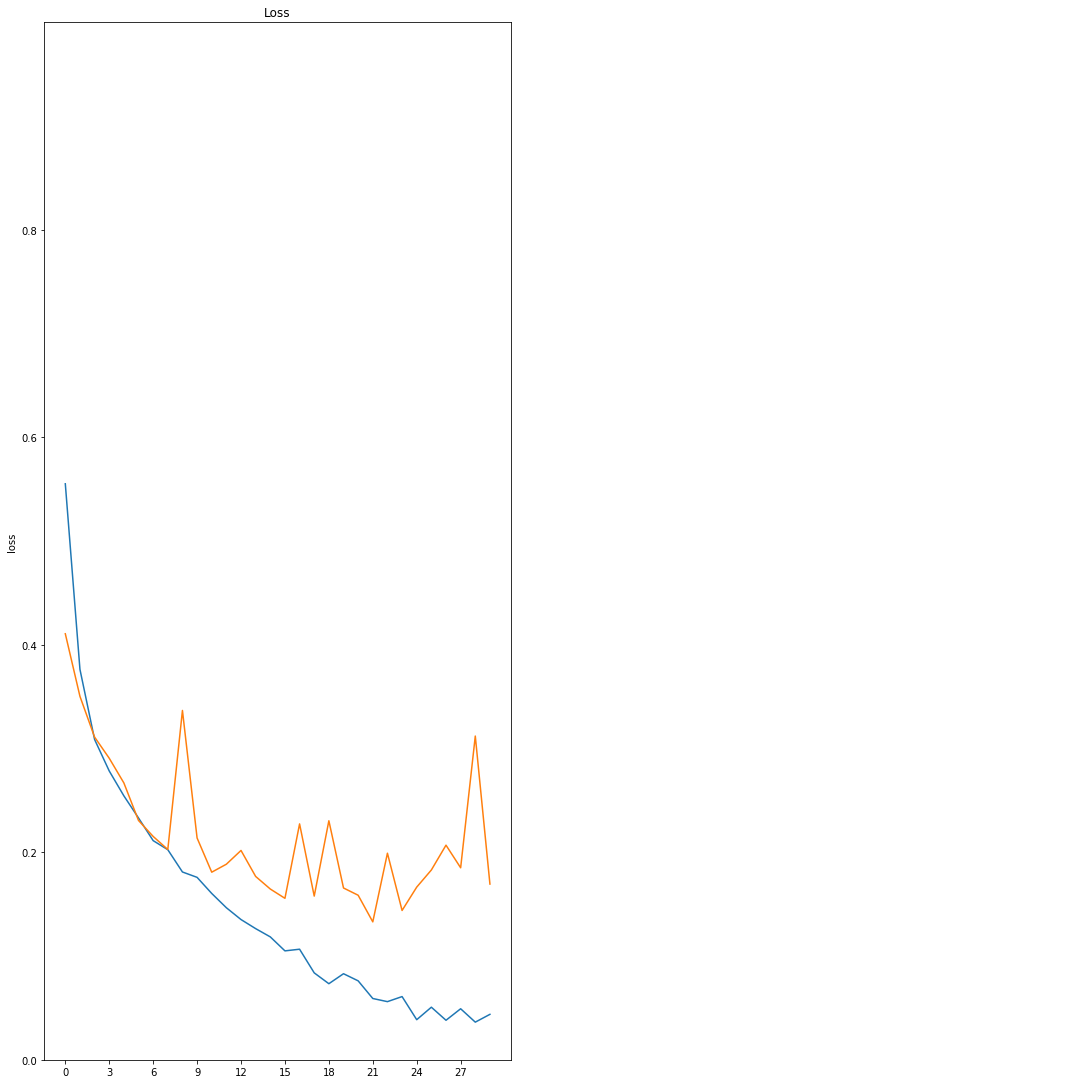

In [93]:
graphs = [res]

fig = plt.figure(figsize = (15, 15))
plt.axis('off')
plt.tight_layout()

for i, hist in enumerate(graphs):
    ax1 = fig.add_subplot(120 + i + 1)
    #plt.setp([ax1], xticks=[], yticks=[])
    ax1.set_ylim(0, 1.0)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title("Loss")
    ax1.set_ylabel('loss')
    #ax1.set_xlabel('epoch')
    ax1.plot(hist.history['loss'])
    ax1.plot(hist.history['val_loss'])
    ax1.xaxis.set_ticks(np.arange(0, epochs, epochs // 10))
    ax1.yaxis.set_ticks(np.arange(0, 1, 0.2))


In [63]:
from keras.models import load_model

prediction_model = load_model('saved_models/weights.best.from_scratch.hdf5')


In [64]:
test_file = 'data/test.json'
test_data = read_data(test_file)


In [69]:
#X_test, y_test, ids = prepare_dataset_ignore_angle(test_data, global_min, global_max)
X_test, y_test, ids = prepare_dataset_with_angle(test_data, global_min, global_max, angle_min, angle_max)

In [70]:
print(X_test.shape)

(8424, 75, 75, 3)


In [71]:
res = prediction_model.predict(X_test)

In [72]:
print(res.shape)

(8424, 1)


In [73]:
print(y_test.shape)

(8424,)


In [74]:
print(y_test)

[0 0 0 ..., 0 0 0]


In [75]:
import csv
headers = ['id', 'is_iceberg']

with open('results.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile, quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(headers)

    for prediction, item_id in zip(res, ids):
        csv_writer.writerow([item_id, np.asscalar(prediction)])

    